In [ ]:
!pip3 install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


# Depression Detection in Social Media Posts

#### Imports

#### Constants

In [ ]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

## Section 1: Load Data

Loading depressive tweets scraped from twitter using [TWINT](https://github.com/haccer/twint) and random tweets from Kaggle dataset [twitter_sentiment](https://www.kaggle.com/ywang311/twitter-sentiment/data).

#### File Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DEPRESSIVE_TWEETS_CSV = '/content/drive/MyDrive/data/depressive_tweets_processed.csv'
RANDOM_TWEETS_CSV = '/content/drive/MyDrive/data/Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = '/content/drive/MyDrive/data/GoogleNews-vectors-negative300.bin.gz'

In [ ]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, header = None, usecols = range(0,6), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [ ]:
depressive_tweets_df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


## Section 2: Data Processing

### Load Pretrained Word2Vec Model

The pretrained vectors for the Word2Vec model is from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit).
Using a Keyed Vectors file, we can get the embedding of any word by calling `.word_vec(word)` and we can get all the words in the model's vocabulary through `.vocab`.

In [ ]:
import sys
file = sys.argv[1]
word2vec = print("EMBEDDING_FILE",file)
#word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

EMBEDDING_FILE -f


### Preprocessing

Preprocessing the tweets in order to:
* Remove links and images
* Remove hashtags
* Remove @ mentions
* Remove emojis
* Remove stop words
* Remove punctuation
* Get rid of stuff like "what's" and making it "what is'
* Stem words so they are all the same tense (e.g. ran -> run)

In [ ]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

Applying the preprocessing `clean_text` function to every element in the depressive tweets and random tweets data.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
depressive_tweets_arr = [x for x in depressive_tweets_df[5]]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Tokenizer

Using a Tokenizer to assign indices and filtering out unfrequent words. Tokenizer creates a map of every unique word and an assigned index to it. The parameter called num_words indicates that we only care about the top 20000 most frequent words.

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

Applying the tokenizer to depressive tweets and random tweets data.

In [ ]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

Number of unique words in tokenizer. Has to be <= 20,000.

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 20008 unique tokens


Pad sequences all to the same length of 140 words.

In [ ]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (3175, 140)
Shape of data_r tensor: (11911, 140)


### Embedding Matrix

The embedding matrix is a `n x m` matrix where `n` is the number of words and `m` is the dimension of the embedding. In this case, `m=300` and `n=20000`. We take the min between the number of unique words in our tokenizer and max words in case there are less unique words than the max we specified.

In [ ]:
# nb_words = min(MAX_NB_WORDS, len(word_index))

# embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

# for (word, idx) in word_index.items():
#   if word in word2vec.vocab: and idx < MAX_NB_WORDS:
#         embedding_matrix[idx] = word2vec.word_vec(word)

### Splitting and Formatting Data

Assigning labels to the depressive tweets and random tweets data, and splitting the arrays into test (60%), validation (20%), and train data (20%). Combine depressive tweets and random tweets arrays and shuffle.

In [ ]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

## Section 3: Building the Model

### Building Model (LSTM + CNN)

The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with it's embeddings, then run the new embedding vector through a convolutional layer. CNNs are excellent at learning spatial structure from data, the convolutional layer takes advantage of that and learn some structure from the sequential data then pass into a standard LSTM layer. Last but not least, the output of the LSTM layer is fed into a standard Dense model for prediction.

In [ ]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

### Compiling Model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 140, 300)          6000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 140, 32)           28832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 70, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 70, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 300)               399600    
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                      

## Section 4: Training the Model

The model is trained `EPOCHS` time, and Early Stopping argument is used to end training if the loss or accuracy don't improve within 3 epochs.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/10
227/227 [==============================] - 7s 14ms/step - loss: 0.5320 - acc: 0.7895 - val_loss: 0.5146 - val_acc: 0.7896
Epoch 2/10
227/227 [==============================] - 3s 15ms/step - loss: 0.5185 - acc: 0.7895 - val_loss: 0.5171 - val_acc: 0.7896
Epoch 3/10
227/227 [==============================] - 6s 25ms/step - loss: 0.5180 - acc: 0.7895 - val_loss: 0.5154 - val_acc: 0.7896
Epoch 4/10
227/227 [==============================] - 6s 24ms/step - loss: 0.5162 - acc: 0.7895 - val_loss: 0.5146 - val_acc: 0.7896
Epoch 5/10
227/227 [==============================] - 4s 20ms/step - loss: 0.5162 - acc: 0.7895 - val_loss: 0.5146 - val_acc: 0.7896
Epoch 6/10
227/227 [==============================] - 7s 31ms/step - loss: 0.5168 - acc: 0.7895 - val_loss: 0.5145 - val_acc: 0.7896
Epoch 7/10
227/227 [==============================] - 4s 20ms/step - loss: 0.5161 - acc: 0.7895 - val_loss: 0.5148 - val_acc: 0.7896
Epoch 8/10
227/227 [==============================] - 4s 16ms/step - 

### Results

Summarize history for accuracy

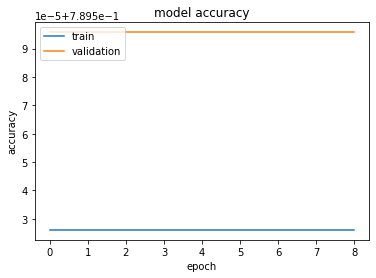

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Summarize history for loss

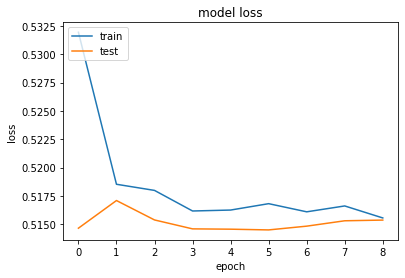

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Percentage accuracy of model

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

95/95 [==============================] - 1s 4ms/step
Accuracy: 78.95%


f1, precision, and recall scores

In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2382
           1       0.00      0.00      0.00       635

    accuracy                           0.79      3017
   macro avg       0.39      0.50      0.44      3017
weighted avg       0.62      0.79      0.70      3017



## Section 5: Comparing the Model to Base Line

In order to evaluate the effectiveness of the LSTM + CNN model, a logistic regression model is trained with the same train data and the same number of epochs, and tested with the same test data.

### Logistic Regression Base Line Model

In [ ]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [ ]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

Training the logistic regression model

In [ ]:
# Logistic Model
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_logistic = [round(logreg.predict(example)) for example in data_test]

Getting the accuracy of the logistic regression model predicting the test data

In [ ]:
# Compare accuracies
accuracy_logistic = get_accuracy(y_logistic, labels_test)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 21.710


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re
from sklearn.model_selection import train_test_split


In [ ]:
import keras
keras.__version__

'2.11.0'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_r, X_r, test_size=0.2, random_state=101)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
max_words=5000
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(data_train, labels_train, epochs=10,validation_data=(data_val, labels_val),callbacks=[checkpoint2])

Epoch 1/10
280/283 [============================>.] - ETA: 0s - loss: 0.5121 - accuracy: 0.7897
Epoch 1: val_accuracy improved from -inf to 0.78960, saving model to rnn_model.hdf5
283/283 [==============================] - 18s 49ms/step - loss: 0.5118 - accuracy: 0.7897 - val_loss: 0.4876 - val_accuracy: 0.7896
Epoch 2/10
280/283 [============================>.] - ETA: 0s - loss: 0.4358 - accuracy: 0.8037
Epoch 2: val_accuracy improved from 0.78960 to 0.79192, saving model to rnn_model.hdf5
283/283 [==============================] - 4s 14ms/step - loss: 0.4352 - accuracy: 0.8044 - val_loss: 0.5047 - val_accuracy: 0.7919
Epoch 3/10
282/283 [============================>.] - ETA: 0s - loss: 0.3623 - accuracy: 0.8392
Epoch 3: val_accuracy did not improve from 0.79192
283/283 [==============================] - 5s 17ms/step - loss: 0.3628 - accuracy: 0.8389 - val_loss: 0.5682 - val_accuracy: 0.7220
Epoch 4/10
282/283 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.87

In [ ]:
sequence = tokenizer.texts_to_sequences(['My life is great'])
max_len=200
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Depressed')
else:
  print('Not depressed')

1/1 [==============================] - 0s 333ms/step
Not depressed
